In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc
# import scvelo as scv

# read the full dataset
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/Stuart_GSE128639/Stuart_bm_v2.h5ad')
data.shape

(30011, 17009)

In [4]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [5]:
# data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B_cell', 'Mono&DC', 'NK', 'Progenitor_cells', 'T_cell']


## Read features

In [6]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [12]:
features_dict.keys()

dict_keys(['B_cell', 'Mono&DC', 'NK', 'Progenitor_cells', 'T_cell'])

In [9]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B_cell,16,8
Mono&DC,20,8
NK,13,3
Progenitor_cells,33,23
T_cell,29,16


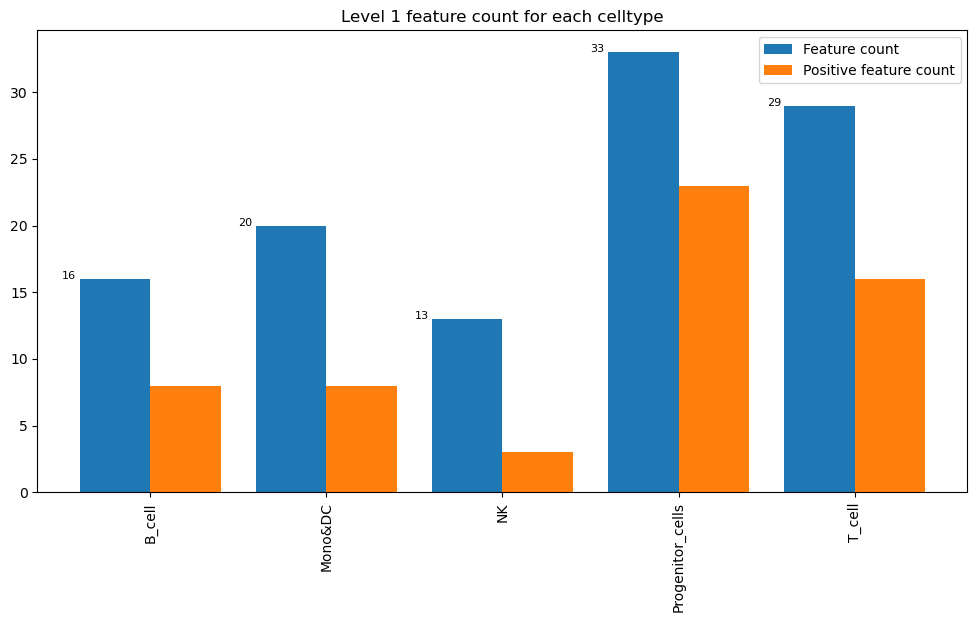

In [10]:
# plot barplot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(count_df.index))
bar_width = 0.4

ax.bar(x - bar_width/2, count_df['Feature_count'], bar_width, label='Feature count')
ax.bar(x + bar_width/2, count_df['Positive_feature_count'], bar_width, label='Positive feature count')

# Add the values to each bar
for i, v in enumerate(count_df['Feature_count']):
    plt.text(i-0.5, v, str(v), fontsize=8)
# for i, v in enumerate(count_df['Positive_feature_count']):
#     plt.text(i, v, str(v), fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(count_df.index)
plt.xticks(rotation=90)
plt.title('Level 1 feature count for each celltype')
ax.legend()
# plt.savefig('L2_feature_count.png', dpi=300, bbox_inches='tight')
plt.show()

## Build classifiers (K-fold CV)

In [11]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [33]:
# do it the old way (without kfold)
celltype = 'CD8_T'
# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]
metrics

[0.9706673260594072,
 0.9209831403615681,
 0.8900667451904201,
 0.9052610562044524,
 0.9884516012570196,
 0.9585112851124526,
 0.8880955201433167]

In [13]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/LR_classifiers')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_loss_diff_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B_cell
[0.9860719146147241, 0.946420340352234, 0.9413349555505309, 0.9437885983310409, 0.9961865039490003, 0.9752895906849094, 0.9358980282955793]
K-fold CV for: Mono&DC
[0.9795076359409988, 0.9583110860078943, 0.9617403086431333, 0.9599538000815805, 0.9967468819051295, 0.9927536837377205, 0.9462496766354326]
K-fold CV for: NK
[0.9887374873043318, 0.8810231473258, 0.8728458498023715, 0.8764309956697485, 0.9935224502293989, 0.9301403739825309, 0.8708085329888142]
K-fold CV for: Progenitor_cells
[0.9866382925387246, 0.9485866274160468, 0.8991986330032082, 0.9229999005556117, 0.9925102263891358, 0.9629455254600903, 0.9162222694438109]
K-fold CV for: T_cell
[0.9814402140260536, 0.9799925682348005, 0.9818072065181973, 0.9808969996165361, 0.9970929898268442, 0.9960661791582496, 0.9628558052237552]


In [14]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B_cell,0.986072,0.946420,0.941335,0.943789,0.996187,0.975290,0.935898
Mono&DC,0.979508,0.958311,0.961740,0.959954,0.996747,0.992754,0.946250
NK,0.988737,0.881023,0.872846,0.876431,0.993522,0.930140,0.870809
Progenitor_cells,0.986638,0.948587,0.899199,0.923000,0.992510,0.962946,0.916222
T_cell,0.981440,0.979993,0.981807,0.980897,0.997093,0.996066,0.962856


In [15]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_l1.csv')

## Read saved .pkl

## Plot classifier K-fold CV metrics

In [16]:
types

['B_cell', 'Mono&DC', 'NK', 'Progenitor_cells', 'T_cell']

In [17]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B_cell,0.986072,0.946420,0.941335,0.943789,0.996187,0.975290,0.935898
Mono&DC,0.979508,0.958311,0.961740,0.959954,0.996747,0.992754,0.946250
NK,0.988737,0.881023,0.872846,0.876431,0.993522,0.930140,0.870809
Progenitor_cells,0.986638,0.948587,0.899199,0.923000,0.992510,0.962946,0.916222
T_cell,0.981440,0.979993,0.981807,0.980897,0.997093,0.996066,0.962856


In [ ]:
# line graph

# Plot metrics for each celltype
ax = all_metrics.plot.line(rot=0, figsize=(8, 6), title='One vs. Rest Logistic Regression using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylim(0, 1.1)

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)
plt.show()

# only plot important metrics
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics[cols].plot.line(rot=0, figsize=(8, 6), title='One vs. Rest Logistic Regression using ADlasso features (converge by loss difference)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylim(0, 1.1)

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)
plt.show()

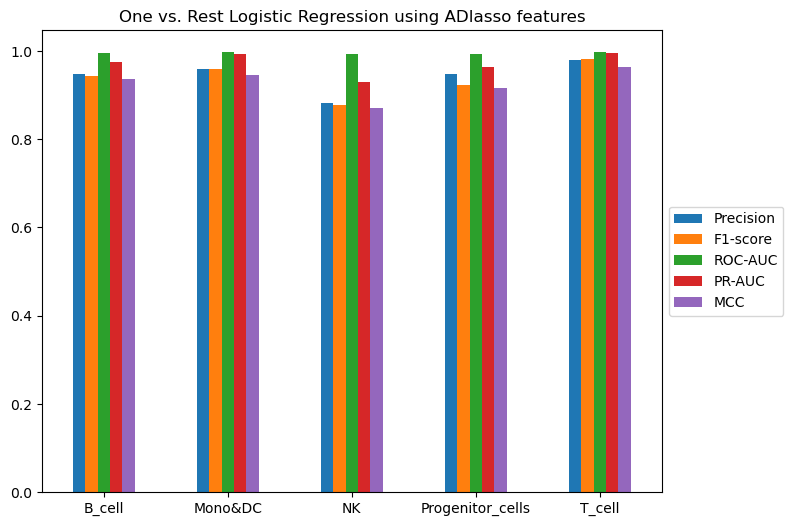

In [21]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression using ADlasso features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Evaluate by DEGn

In [22]:
count_df

,Feature_count,Positive_feature_count
B_cell,16,8
Mono&DC,20,8
NK,13,3
Progenitor_cells,33,23
T_cell,29,16


In [23]:
# Read DEG table
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/L1_DEG')

celltype = 'B_cell'
DEG_table = pd.read_csv(celltype + '_DEG500.csv', index_col=0)
n_features = count_df.loc[celltype, 'Feature_count']  # 3902
DEGn = DEG_table['names'][:n_features].tolist()

In [24]:
n_features

16

In [25]:
DEGn

['CD74',
 'HLA-DRA',
 'CD79A',
 'HLA-DPB1',
 'MS4A1',
 'CD79B',
 'HLA-DPA1',
 'CD37',
 'HLA-DQB1',
 'IGKC',
 'CD52',
 'HLA-DQA1',
 'HLA-DRB5',
 'HLA-DRB1',
 'LTB',
 'IGHM']

In [26]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [27]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/L1_DEG


In [29]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG500.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: B_cell
n: 16
(30011, 16)
Constructing classifier for: Mono&DC
n: 20
(30011, 20)
Constructing classifier for: NK
n: 13
(30011, 13)
Constructing classifier for: Progenitor_cells
n: 33
(30011, 33)
Constructing classifier for: T_cell
n: 29
(30011, 29)


In [30]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B_cell,0.980676,0.928087,0.915663,0.921833,0.993447,0.967256,0.910836
Mono&DC,0.979177,0.952994,0.966057,0.959481,0.996495,0.992121,0.945510
NK,0.992004,0.925094,0.898182,0.911439,0.997414,0.965565,0.907361
Progenitor_cells,0.976179,0.931868,0.791045,0.855701,0.965907,0.899491,0.846174
T_cell,0.973180,0.971566,0.973233,0.972398,0.994322,0.993217,0.946318


In [32]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table')
all_metrics_DEG.to_csv('L1_DEGn_metrics.csv')

In [ ]:
# line graph

# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics_DEG[cols].plot.line(rot=0, figsize=(8, 6), title='One vs. Rest Logistic Regression using DEGn as features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)
ax.set_ylim(0, 1.1)

plt.show()

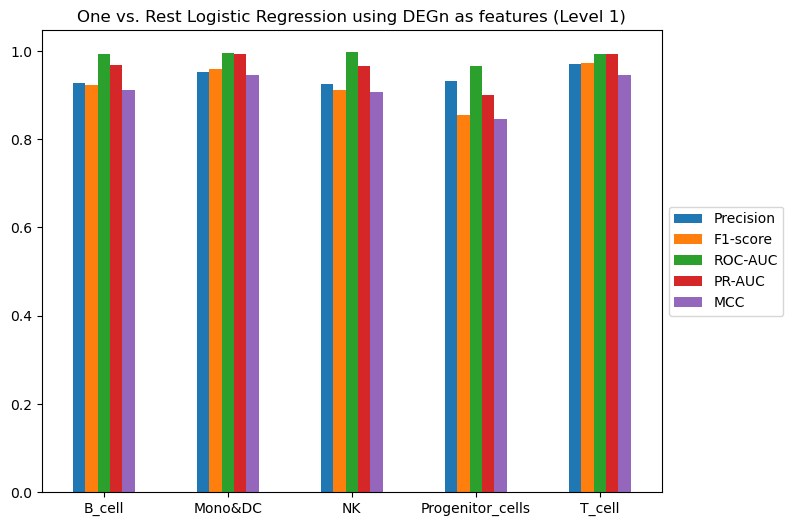

In [33]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [34]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B_cell,0.986072,0.946420,0.941335,0.943789,0.996187,0.975290,0.935898
Mono&DC,0.979508,0.958311,0.961740,0.959954,0.996747,0.992754,0.946250
NK,0.988737,0.881023,0.872846,0.876431,0.993522,0.930140,0.870809
Progenitor_cells,0.986638,0.948587,0.899199,0.923000,0.992510,0.962946,0.916222
T_cell,0.981440,0.979993,0.981807,0.980897,0.997093,0.996066,0.962856


In [35]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B_cell,0.980676,0.928087,0.915663,0.921833,0.993447,0.967256,0.910836
Mono&DC,0.979177,0.952994,0.966057,0.959481,0.996495,0.992121,0.945510
NK,0.992004,0.925094,0.898182,0.911439,0.997414,0.965565,0.907361
Progenitor_cells,0.976179,0.931868,0.791045,0.855701,0.965907,0.899491,0.846174
T_cell,0.973180,0.971566,0.973233,0.972398,0.994322,0.993217,0.946318


In [36]:
AD_minus_DEG = all_metrics - all_metrics_DEG
AD_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B_cell,0.005396,0.018334,0.025672,0.021956,0.002740,0.008033,0.025062
Mono&DC,0.000331,0.005317,-0.004317,0.000472,0.000252,0.000633,0.000740
NK,-0.003267,-0.044070,-0.025336,-0.035008,-0.003891,-0.035424,-0.036553
Progenitor_cells,0.010460,0.016718,0.108154,0.067299,0.026603,0.063454,0.070048
T_cell,0.008260,0.008427,0.008575,0.008499,0.002771,0.002849,0.016537


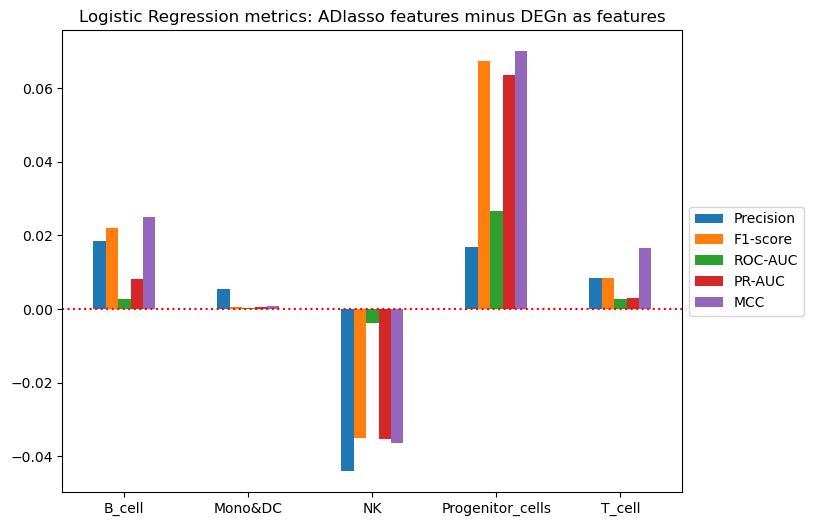

In [37]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = AD_minus_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression metrics: ADlasso features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
